<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/LS_DS17_432_Convolution_Neural_Networks_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## *Data Science Unit 4 Sprint 3 Module 2*
# Convolutional Neural Networks (CNNs)


- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/train/mountain/art1131.jpg?raw=1)|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/validation/forest/cdmc317.jpg?raw=1)|

The problem is relatively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several different possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to add additional fully connected layers to our model. When we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can experiment with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)
```

Apply the transfer learning above to classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

Steps: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pre-trained layers from resnet
4. Report your model's accuracy

## Load in Data

This surprisingly more difficult than it seems, because you are working with directories of images instead of a single file. This boiler plate will help you download a zipped version of the directory of images. The directory is organized into "train" and "validation" which you can use inside an `ImageGenerator` class to stream batches of images thru your model.  


### Download & Summarize the Data

This step is completed for you. Just run the cells and review the results. 

In [1]:
import tensorflow as tf
import os

_URL = 'https://github.com/skhabiri/ML-DeepLearning/raw/main/mount_forest/data.zip'

In [2]:
"""
By default the file at the url `origin` is downloaded to the
cache_dir `~/.keras`, placed in the cache_subdir `datasets`,
and given the filename `fname`. 
"""
path_to_zip = tf.keras.utils.get_file(fname='./data.zip', origin=_URL, extract=True)

In [3]:
path_to_zip

'/Users/shahnam/.keras/datasets/./data.zip'

In [4]:
# Path to unzipped data directory
PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

In [5]:
PATH

'/Users/shahnam/.keras/datasets/./data'

In [6]:
# add {} or $ before the variable when used with magic command
!ls {os.path.dirname(path_to_zip)}

__MACOSX                   data.zip
cifar-10-batches-py        fashion-mnist
cifar-10-batches-py.tar.gz imdb.npz
data                       mnist.npz


In [7]:
!ls $PATH

train      validation


In [8]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [9]:
train_dir

'/Users/shahnam/.keras/datasets/./data/train'

In [10]:
# unlike !ls, os.listdir() takes paython variable as path
os.listdir(train_dir)

['forest', '.DS_Store', 'mountain']

In [11]:
!ls $train_dir

forest   mountain


In [12]:
train_mountain_dir = os.path.join(train_dir, 'mountain')  # directory with our training mountain pictures
train_forest_dir = os.path.join(train_dir, 'forest')  # directory with our training forest pictures
validation_mountain_dir = os.path.join(validation_dir, 'mountain')  # directory with our validation mountain pictures
validation_forest_dir = os.path.join(validation_dir, 'forest')  # directory with our validation forest pictures

In [13]:
type(os.listdir(train_mountain_dir))

list

In [14]:
num_mountain_tr = len(os.listdir(train_mountain_dir))
num_forest_tr = len(os.listdir(train_forest_dir))

num_mountain_val = len(os.listdir(validation_mountain_dir))
num_forest_val = len(os.listdir(validation_forest_dir))

total_train = num_mountain_tr + num_forest_tr
total_val = num_mountain_val + num_forest_val

In [15]:
print('total training mountain images:', num_mountain_tr)
print('total training forest images:', num_forest_tr)

print('total validation mountain images:', num_mountain_val)
print('total validation forest images:', num_forest_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training mountain images: 254
total training forest images: 270
total validation mountain images: 125
total validation forest images: 62
--
Total training images: 524
Total validation images: 187


### Keras `ImageGenerator` to Process the Data

The `ImageGenerator` class reads in batches of data from a directory and pass them to the model one batch at a time. Just like large text files, this method is advantageous, because it stifles the need to load a bunch of images into memory. 

Check out the documentation for this class method: [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class). You'll expand it's use in the third part objective.

In [16]:
batch_size = 16
epochs = 50
# 224 is resNet50 input size requirement
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [18]:
[m for m in dir(train_image_generator) if not m.startswith("_")]

['apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'principal_components',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertical_flip',
 'width_shift_range',
 'zca_epsilon',
 'zca_whitening',
 'zoom_range']

In [19]:
# for image_generator, directory path should be to some subdirectory containing the images not to the directory containing images
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 533 images belonging to 2 classes.


In [20]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 195 images belonging to 2 classes.


In [21]:
len(os.listdir(validation_mountain_dir))

125

* DataGenerator structure:

`val_data_gen[batch#][images_arrays, target_labels]`

In [30]:
val_data_gen[0][1][:10]

array([1., 1., 0., 1., 1., 1., 0., 0., 0., 1.], dtype=float32)

In [36]:
print("\n number of batches: len(val_data_gen):", len(val_data_gen))
# [0]:images; [1]:target labels
print("\n [images, target_labels]: len(val_data_gen[0]:", len(val_data_gen[0]))
print("\n number of images in a batch: len(val_data_gen[0][0]:", len(val_data_gen[0][0]))
# 16 images, each of them 224x224x3(rgb) size
print("\n [#of images, dimension of images]: val_data_gen[0][0].shape:", val_data_gen[0][0].shape)
# 16 binary target labels for mountain and forest
print("\ntarget array:\n", val_data_gen[0][1][:16])


 number of batches: len(val_data_gen): 13

 [images, target_labels]: len(val_data_gen[0]: 2

 number of images in a batch: len(val_data_gen[0][0]: 16

 [#of images, dimension of images]: val_data_gen[0][0].shape: (16, 224, 224, 3)

target array:
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]


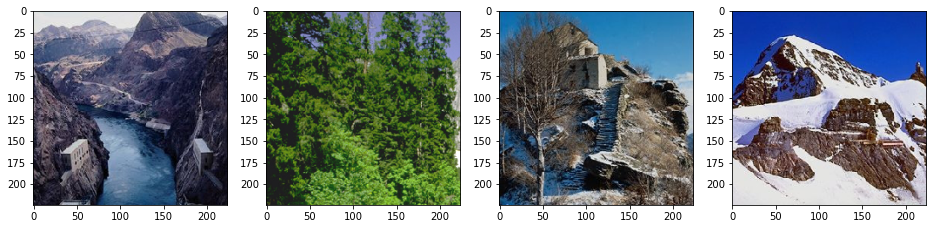

In [39]:
# plot i'th image of the i'th batch
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
for i in range(1,5,1):
    plt.subplot(1,4,i)
    plt.imshow(val_data_gen[i][0][i])

## Instantiate Model
We take off the flatten and all the dense top layers from the model to customize it with our data. However, we also disable weight update for all the ResNet50 remaining layers to avoid over writing them while the update will take place on our customized top layers. GlobalAveragePooling2D is used instead of flatten layer before connecting to the top layers. We use keras functional API, Model, instead of the Sequential model to build the model.

In [40]:
import numpy as np
 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API
 
resnet = ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 7s 0us/step


In [41]:
"""
GlobalAveragePooling2D: for spatial data.
Input shape:
  - If `data_format='channels_last'`:
    4D tensor with shape `(batch_size, rows, cols, channels)`.
  - If `data_format='channels_first'`:
    4D tensor with shape `(batch_size, channels, rows, cols)`.

Output shape:
  2D tensor with shape `(batch_size, channels)`.
"""
for layer in resnet.layers:
    layer.trainable = False

# resnet.output is 2048
x = resnet.output

# output tensor (batch_size, channels)
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# input shape is 224x224x3 provided by ImageDataGenerator
model = Model(resnet.input, predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Fit Model
In fit_generator method, `steps_per_epoch` and `validation_steps` would define how many batches for traing and validation data per epoch we will have. Here since we have a desired batch size, we adjust the mentioned parameters such that we accomplish close to desired batch size.

In [43]:
history = model.fit(
    train_data_gen,
    # integer division
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/50
32/32 [==============================] - 47s 1s/step - loss: 0.7719 - accuracy: 0.5489 - val_loss: 0.5790 - val_accuracy: 0.8125
Epoch 2/50
32/32 [==============================] - 45s 1s/step - loss: 0.5735 - accuracy: 0.7656 - val_loss: 0.4805 - val_accuracy: 0.7500
Epoch 3/50
32/32 [==============================] - 43s 1s/step - loss: 0.5609 - accuracy: 0.6856 - val_loss: 0.4485 - val_accuracy: 0.8636
Epoch 4/50
32/32 [==============================] - 45s 1s/step - loss: 0.4440 - accuracy: 0.7951 - val_loss: 0.4923 - val_accuracy: 0.8011
Epoch 5/50
32/32 [==============================] - 46s 1s/step - loss: 0.4282 - accuracy: 0.8156 - val_loss: 0.4028 - val_accuracy: 0.8580
Epoch 6/50
32/32 [==============================] - 45s 1s/step - loss: 0.4257 - accuracy: 0.8120 - val_loss: 0.4064 - val_accuracy: 0.8352
Epoch 7/50
32/32 [==============================] - 44s 1s/step - loss: 0.3619 - accuracy: 0.8453 - val_loss: 0.3370 - val_accuracy: 0.8864
Epoch 8/50
32/32 [==

In [44]:
model.evaluate(val_data_gen, verbose=2)

13/13 - 12s - loss: 0.4508 - accuracy: 0.8410


[0.45082888007164, 0.8410256505012512]

# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

### How to interpret the output log metrics
1. *Since ImageDataGenerator has constructed the input data in batches, do not specify the steps or batch_size for training or validation data.*
2. *`accuracy` in the output log file of model.fit() is calculated once for each batch of epoch. The last one that is recorded in history dictionary and output log per epoch, is indeed the accuracy of the **last batch** of the training data for that epoch. Note that the batches are selected randomly. at each epoch*
3. *`val_accuracy` in the output log file or history dictionary of model.fit(), is only calculated once at the end of each epoch. After the last batch of an epoch, the entire validation data is run through the model to get the validation score in that epoch.
4. `model.evaluate(val_data)` should return the same metric as the validation metric of the last epoch.
4. `model.evaluate(train_data)` is different from the one in history log. This is for the entire train set not for a batch in an epoch.


### How to save the best epoch model instead of the last epoch?
To save the best epoch model use ModelCheckpoint call back. 
ex/
```
epochs = 100
# other parameters...

model.fit(x, y,
          epochs=epochs,
          validation_data=valid,
          verbose=2,
          callbacks=[
              TerminateOnNaN(),
              TensorBoard('./logs'),
              ModelCheckpoint('best.h5', save_best_only=True),
              ...
          ])
# the model is holding the weights optimized for 100 epochs.

model.load_weights('best.h5')  # load weights that generated the min val loss.
```

### Build and Compile

In [175]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import initializers

model1 = Sequential()

model1.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu', input_shape=(224,224,3)))

#default strides is the same as pool_size
model1.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'))

model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(Flatten())
model1.add(Dense(64, activation='relu',
                kernel_initializer=initializers.RandomNormal(stddev=0.01),
                bias_initializer=initializers.Zeros()))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))


In [176]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [177]:
# Compile Model
model1.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

### Callbacks

In [259]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

# Save the latest epoch model with the highest validation accuracy
filepath="./best_model/best-{epoch:02d}-{val_accuracy:.4f}.hf5"
checkpoint_cb = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='auto')

class BatchHistory(Callback):
    """
    A custom callback to record accuracy number for each batch
    """
    # overrideing the parent methods
    def on_train_begin(self, logs={}):
        # for 34 steps training set
        self.accuracy = [[] for _ in range(34)]
    
    # parent class has a on_batch_end method that recieves 
    # batch and logs asinput parameters. However, we'll over write the method here
    def on_batch_end(self, batch, logs={}):
        self.accuracy[batch].append(logs.get('accuracy'))

# Instantiate the callbacks
batchhistory_cb = BatchHistory()
callbacks_list = [checkpoint_cb, batchhistory_cb]

### Fit and Evaluate

In [223]:
# Fit Model
history = model1.fit(
    train_data_gen,
#     // is integer division
#     steps_per_epoch=total_train // batch_size,
    epochs=10,
    validation_data=val_data_gen,
#     validation_steps=total_val // batch_size,
    callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - 15s 445ms/step - loss: 0.1393 - accuracy: 0.9418 - val_loss: 0.2235 - val_accuracy: 0.9026

Epoch 00001: val_accuracy improved from -inf to 0.90256, saving model to ./best_model/best-01-0.9026.hf5
INFO:tensorflow:Assets written to: ./best_model/best-01-0.9026.hf5/assets
Epoch 2/10
34/34 [==============================] - 15s 446ms/step - loss: 0.1241 - accuracy: 0.9550 - val_loss: 0.1372 - val_accuracy: 0.9282

Epoch 00002: val_accuracy improved from 0.90256 to 0.92821, saving model to ./best_model/best-02-0.9282.hf5
INFO:tensorflow:Assets written to: ./best_model/best-02-0.9282.hf5/assets
Epoch 3/10
34/34 [==============================] - 16s 465ms/step - loss: 0.0790 - accuracy: 0.9681 - val_loss: 0.3064 - val_accuracy: 0.8923

Epoch 00003: val_accuracy did not improve from 0.92821
Epoch 4/10
34/34 [==============================] - 16s 459ms/step - loss: 0.0803 - accuracy: 0.9700 - val_loss: 0.2801 - val_accuracy: 0.9077

Epoch 00

* **Let's check the entire training set accuracy with the final model and re-evaluate the validation data accuracy**

In [224]:
# model1.evaluate(val_data_gen, steps=total_val // batch_size)
model1.evaluate(train_data_gen), model1.evaluate(val_data_gen)

13/13 [==============================] - 1s 99ms/step - loss: 0.2119 - accuracy: 0.9231


([0.016082199290394783, 0.998123824596405],
 [0.21191750466823578, 0.9230769276618958])

**That validation accuracy matches the last val_accuracy on log file, but the traing accuracy is different as expected. The history dictionary logs the metrics of the latst batches of each epoch**

In [230]:
history.history

{'loss': [0.13931939005851746,
  0.12409592419862747,
  0.07904864102602005,
  0.08033338189125061,
  0.06508395820856094,
  0.05613555386662483,
  0.06726101785898209,
  0.04528189077973366,
  0.05058347433805466,
  0.052745625376701355],
 'accuracy': [0.9418386220932007,
  0.9549718499183655,
  0.9681050777435303,
  0.9699812531471252,
  0.9737336039543152,
  0.9756097793579102,
  0.9737336039543152,
  0.9831144213676453,
  0.9887429475784302,
  0.9868667721748352],
 'val_loss': [0.2235240489244461,
  0.13718678057193756,
  0.30640095472335815,
  0.28006577491760254,
  0.48459309339523315,
  0.4107750654220581,
  0.27105721831321716,
  0.34841427206993103,
  0.25833258032798767,
  0.21191748976707458],
 'val_accuracy': [0.9025641083717346,
  0.928205132484436,
  0.892307698726654,
  0.9076923131942749,
  0.8410256505012512,
  0.8871794939041138,
  0.9179487228393555,
  0.9076923131942749,
  0.9179487228393555,
  0.9230769276618958]}

**The custom callback has the accuracy of all the batches.**

In [237]:
print(len(batchhistory_cb.accuracy))
# accuracy numbers from the last batch of all epochs
np.array(batchhistory_cb.accuracy)[33]

34


array([0.94183862, 0.95497185, 0.96810508, 0.96998125, 0.9737336 ,
       0.97560978, 0.9737336 , 0.98311442, 0.98874295, 0.98686677])

**evaluate() returns loss and accuracy metrics while predict returns each classes' continious numeric representation**

In [244]:
# predict the continious numeric output for the first four images. 
# The output can be binned into a bunary class
pred = model1.predict(val_data_gen)
pred[:4]

array([[7.0599976e-06],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.2035065e-02]], dtype=float32)

**Load the best model and confirm the evaluation score of the best model vs history dictionary**

In [256]:
# load the model with the best validation accuracy
best_model = tf.keras.models.load_model("./best_model/best-02-0.9282.hf5")
np.testing.assert_allclose(best_model.evaluate(val_data_gen)[-1], max(history.history.get('val_accuracy')), 1e-3)

13/13 [==============================] - 1s 75ms/step - loss: 0.1372 - accuracy: 0.9282


## Image Data Augmentation

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. In each epoch, the ImageDataGenerator applies a transformation on the images you have and use the transformed images for training. The set of transformations includes rotation, zooming, etc. By doing this you're somehow creating new data (i.e. also called data augmentation), but obviously the generated images are not totally different from the original ones. This way the learned model may be more robust and accurate as it is trained on different variations of the same image. We need to emphasize that the model is trained on a random augmented version of the same training images which is going to vary from one epoch to another. Simply, you should be able to modify our image generator for the problem. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

In [261]:
train_dir

'/Users/shahnam/.keras/datasets/./data/train'

### Instantiate the ImageDataGenerator class

In [ ]:
# Define the Model
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16

train_image_generator1 = ImageDataGenerator(
        rotation_range=20,  # Degree range for random rotations.
        rescale=1./255,
        shear_range=0.1,  # dragging the image
        brightness_range=[0.5,1.0],
        zoom_range=(0.8, 1.2),
        horizontal_flip=True,
        vertical_flip = False,
        # fill_mode is the strategy used for filling in newly created pixels
        fill_mode='nearest')

validation_image_generator1 = ImageDataGenerator(
        rotation_range=45,
        # random % of the shift
        width_shift_range=[-0.3, 0.3],
        height_shift_range=[-0.35, 0.35],
        rescale=1./255,
        # dragging the image
        shear_range=0.1,
        # no brightness to 20% of the original brightness (it darkens)
        brightness_range=[0.2,1.0],
        zoom_range=(0.8, 1.2),
        horizontal_flip=True,
        vertical_flip = False,
        # fill_mode is the strategy used for filling in newly created pixels
        fill_mode='nearest')

### Generate augmented image data

In [334]:
train_data_gen = train_image_generator.flow_from_directory( batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           seed=110,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
train_data_gen1 = train_image_generator1.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           seed=110,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen1 = validation_image_generator1.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 533 images belonging to 2 classes.
Found 533 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


In [375]:
print(type(val_data_gen1))

# all the target labels
print("target labels[::20]=", val_data_gen1.labels[::20])

# number of batches
print("number of batches:", len(val_data_gen1))

# in 5th batch
print("X, y arrays in one batch:", len(val_data_gen1[5]))

# 5'th batch X (batch_size, row, column, channel)
print("X (batch_size, row, column, channel):", val_data_gen1[5][0].shape)

# 5'th batch y
print("y (batch_size,)", val_data_gen1[5][1].shape)

<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
target labels[::20]= [0 0 0 0 1 1 1 1 1 1]
number of batches: 13
X, y arrays in one batch: 2
X (batch_size, row, column, channel): (16, 224, 224, 3)
y (batch_size,) (16,)


**Image data generator dimensions:**
- batch number
    - X, y
        - X (batch_size, row, column, channel), y (batch_size,)

* **Let's compare original images and augmented ones**

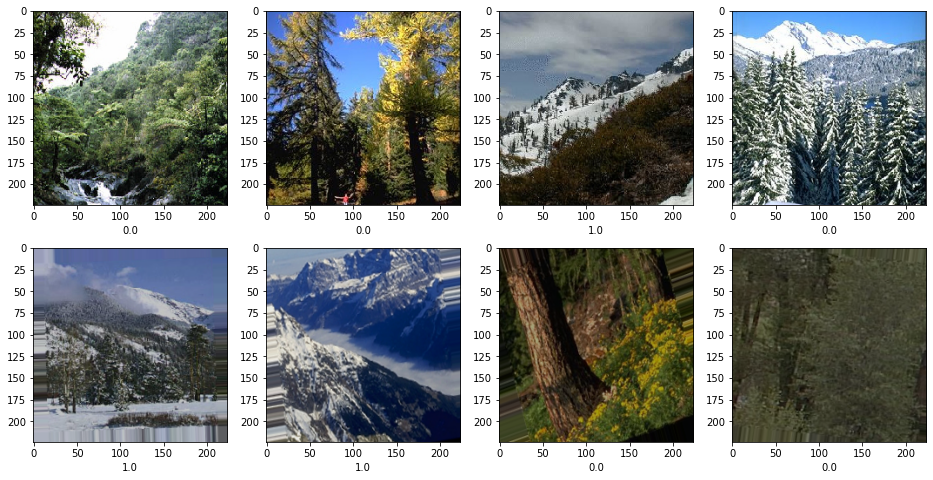

In [376]:
plt.subplots(figsize=(16,8))

for i in range(1,5,1):
    plt.subplot(2,4,i)
    plt.imshow(train_data_gen[i][0][15])
    plt.xlabel(train_data_gen[i][1][15])
    
    # 2'nd row
    plt.subplot(2,4,i+4)
    plt.imshow(train_data_gen1[i][0][15])
    plt.xlabel(train_data_gen1[i][1][15])


In [339]:
# Save the latest epoch model with the highest validation accuracy
filepath="./best_model2/best-{epoch:02d}-{val_accuracy:.4f}.hf5"
checkpoint_cb = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='auto')
callbacks_list = [checkpoint_cb, batchhistory_cb]

# Fit Model
history = model1.fit(
    train_data_gen1,
    epochs=10,
    validation_data=val_data_gen1,
    callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - 19s 544ms/step - loss: 0.2339 - accuracy: 0.9362 - val_loss: 0.3258 - val_accuracy: 0.8564

Epoch 00001: val_accuracy improved from -inf to 0.85641, saving model to ./best_model2/best-01-0.8564.hf5
INFO:tensorflow:Assets written to: ./best_model2/best-01-0.8564.hf5/assets
Epoch 2/10
34/34 [==============================] - 19s 544ms/step - loss: 0.1859 - accuracy: 0.9212 - val_loss: 0.4658 - val_accuracy: 0.8359

Epoch 00002: val_accuracy did not improve from 0.85641
Epoch 3/10
34/34 [==============================] - 18s 545ms/step - loss: 0.1671 - accuracy: 0.9193 - val_loss: 0.3959 - val_accuracy: 0.8410

Epoch 00003: val_accuracy did not improve from 0.85641
Epoch 4/10
34/34 [==============================] - 20s 579ms/step - loss: 0.1190 - accuracy: 0.9531 - val_loss: 0.6648 - val_accuracy: 0.8308

Epoch 00004: val_accuracy did not improve from 0.85641
Epoch 5/10
34/34 [==============================] - 20s 575ms/step - loss: 0.1

In [340]:
# load the model with the best validation accuracy
best_model2 = tf.keras.models.load_model("./best_model2/best-09-0.8769.hf5")
best_model.evaluate(val_data_gen1)

13/13 [==============================] - 3s 230ms/step - loss: 0.2723 - accuracy: 0.8769


[0.27233269810676575, 0.8769230842590332]

In [359]:
np.expand_dims(val_data_gen1[11][0][15], axis=0).shape

(1, 224, 224, 3)

In [363]:
val_data_gen1.samples

195

### Prediction

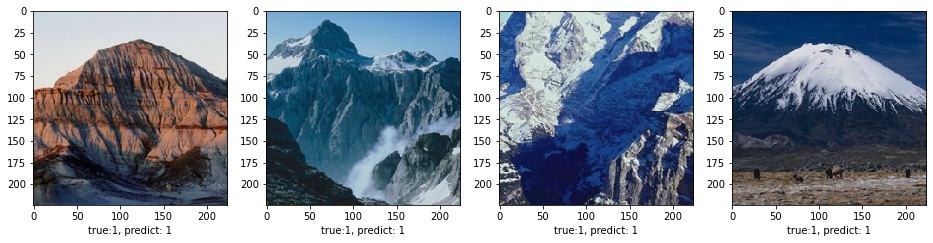

In [393]:
plt.subplots(figsize=(16,16))

for i in range(1,5,1):
    plt.subplot(1,4,i)
    img = val_data_gen[i][0][10]
    plt.imshow(img)
    pred = best_model2.predict(np.expand_dims(val_data_gen[i][0][10], axis=0))
    
    # convert the continious output number to digitized class number
    pred_class = np.where(pred<0.5, 0, 1).item(0)
    plt.xlabel(f"true:{val_data_gen[i][1][10]:.0f}, predict: {pred_class}")

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language